In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import itertools
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [4]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [5]:
X = [] # ELA converted images
Y = [] # 0 for forged, 1 for authentic

In [6]:
# Load authentic images
path = 'dataset/authentic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)

In [7]:
# Load forged images
path = 'dataset/forged'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)

In [8]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)


In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [11]:
base_model_vgg = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

for layer in base_model_vgg.layers:
    layer.trainable = False

x_vgg = layers.Flatten()(base_model_vgg.output)
x_vgg = layers.Dense(1024, activation='relu')(x_vgg)
x_vgg = layers.Dropout(0.2)(x_vgg)
x_vgg = layers.Dense(2, activation='softmax')(x_vgg)

model_vgg = tf.keras.models.Model(base_model_vgg.input, x_vgg)

model_vgg.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mc_vgg = ModelCheckpoint(filepath="./vgg_best_model.keras",
                         monitor='val_accuracy',
                         verbose=1,
                         save_best_only=True,
                         mode='auto')

vgg_callbacks = [mc_vgg]

vgg_history = model_vgg.fit(X_train, Y_train,
                            epochs=32,
                            validation_data=(X_val, Y_val),
                            callbacks=vgg_callbacks)

model_vgg.save('X_train.keras')

Epoch 1/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5868 - loss: 0.8814
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to ./vgg_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 596ms/step - accuracy: 0.5880 - loss: 0.8778 - val_accuracy: 0.8250 - val_loss: 0.4510
Epoch 2/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7996 - loss: 0.4591
Epoch 2: val_accuracy did not improve from 0.82500
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.7991 - loss: 0.4595 - val_accuracy: 0.6675 - val_loss: 0.6423
Epoch 3/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7836 - loss: 0.4693
Epoch 3: val_accuracy improved from 0.82500 to 0.88500, saving model to ./vgg_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.7839 - loss: 0.4689 - val_accuracy: 0.8850 - val_loss: 0.3194
Epoch 4/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8247 - loss: 0.3956
Epoch 4: val_accuracy did not improve from 0.88500
50/50 ━━━━━━━

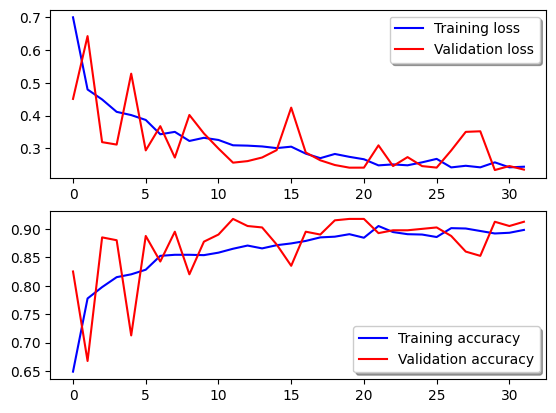

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(vgg_history.history['loss'], color='b', label="Training loss")
ax[0].plot(vgg_history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(vgg_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(vgg_history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step


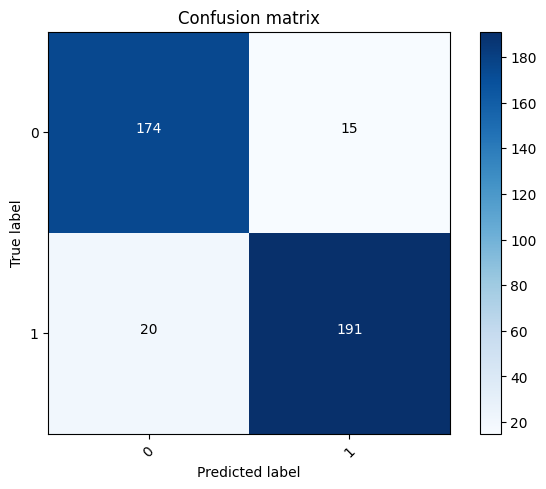

In [13]:
Y_pred_vgg = model_vgg.predict(X_val)
Y_pred_classes_vgg = np.argmax(Y_pred_vgg, axis=1)
Y_true_vgg = np.argmax(Y_val, axis=1)
confusion_mtx_vgg = confusion_matrix(Y_true_vgg, Y_pred_classes_vgg)

plot_confusion_matrix(confusion_mtx_vgg, classes=range(2))

In [14]:
print("Classification report for VGG16:")
print(classification_report(Y_true_vgg, Y_pred_classes_vgg, target_names=['forged', 'authentic']))
accuracy_vgg = accuracy_score(Y_true_vgg, Y_pred_classes_vgg)
print("Overall accuracy for VGG16: {:.2f}%".format(accuracy_vgg*100))

Classification report for VGG16:
              precision    recall  f1-score   support

      forged       0.90      0.92      0.91       189
   authentic       0.93      0.91      0.92       211

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Overall accuracy for VGG16: 91.25%


In [15]:
sample_paths = [
    'dataset/authentic/372.jpg',
    'dataset/authentic/371.jpg',
    'dataset/authentic/370.jpg',
    'dataset/authentic/369.jpg',
    'dataset/authentic/368.jpg',
    'dataset/authentic/367.jpg',
    'dataset/authentic/366.jpg',
    'dataset/authentic/365.jpg',
    'dataset/forged/1468_1469.png',
    'dataset/forged/2625_2626.png',
    'dataset/forged/2622_2623.png',
    'dataset/forged/2588_2589.png',
    'dataset/forged/2570_2571.png',
    'dataset/forged/2564_2565.png',
    'dataset/forged/2556_2557.png',
    'dataset/forged/2540_2541.png',
    'dataset/forged/2527_2528.png',
    'dataset/forged/1276_1277.png',
]

In [16]:
for sample_path in sample_paths:
    image = prepare_image(sample_path)
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model_vgg.predict(image)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    class_names = ['forged', 'authentic']
    print(f'Image: {sample_path}, Predicted class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Image: dataset/authentic/372.jpg, Predicted class: authentic, Confidence: 90.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: dataset/authentic/371.jpg, Predicted class: authentic, Confidence: 97.70%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: dataset/authentic/370.jpg, Predicted class: authentic, Confidence: 64.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: dataset/authentic/369.jpg, Predicted class: authentic, Confidence: 99.44%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: dataset/authentic/368.jpg, Predicted class: authentic, Confidence: 90.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: dataset/authentic/367.jpg, Predicted class: forged, Confidence: 79.22%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image: dataset/authentic/366.jpg, Predicted class: forged, Confidence: 61.20%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: dataset/authentic/365.jpg, Predicted class: forged, Confidence: 52.16%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image: dataset/forg

In [17]:
correct = 0
total = 0

for dirname, _, filenames in os.walk('dataset/forged'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_vgg.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 0:
                correct += 1

for dirname, _, filenames in os.walk('dataset/authentic'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_vgg.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 1:
                correct += 1

print(f'Total: {total}, Correct: {correct}, Accuracy: {correct / total * 100.0:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━